# Nomic Embeddings

Nomic has released a new embedding model with strong performance for long context retrieval (8k context window).

The cookbook walks through the process of building and deploying (via LangServe) a RAG app using Nomic embeddings.

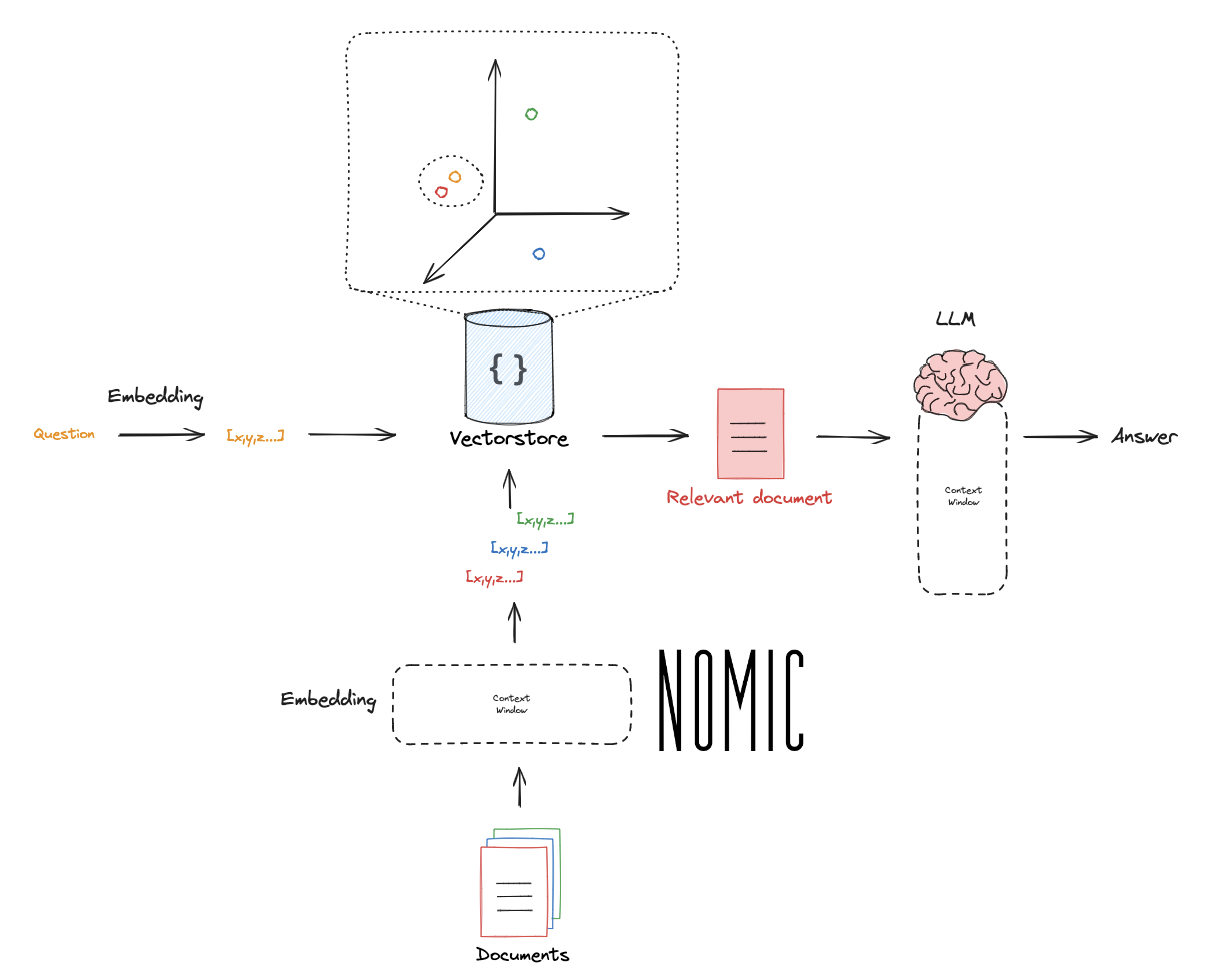

## Signup

Get your API token, then run:
```
! nomic login
```

Then run with your generated API token 
```
! nomic login < token > 
```

In [ ]:
! nomic login

In [ ]:
! nomic login token

In [ ]:
! pip install -U langchain-nomic langchain-chroma langchain-community tiktoken langchain-openai langchain

In [ ]:
# Optional: LangSmith API keys
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = "api_key"

## Document Loading

Let's test 3 interesting blog posts.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

## Splitting 

Long context retrieval 

In [ ]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=7500, chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
for d in doc_splits:
    print("The document is %s tokens" % len(encoding.encode(d.page_content)))

## Index 

Nomic embeddings [here](https://docs.nomic.ai/reference/endpoints/nomic-embed-text). 

In [ ]:
import os

from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_nomic import NomicEmbeddings
from langchain_nomic.embeddings import NomicEmbeddings

In [ ]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1"),
)
retriever = vectorstore.as_retriever()

## RAG Chain

We can use the Mistral `v0.2`, which is [fine-tuned for 32k context](https://x.com/dchaplot/status/1734198245067243629?s=20).

We can [use Ollama](https://ollama.ai/library/mistral) -
```
ollama pull mistral:instruct
```

We can also run [GPT-4 128k](https://openai.com/blog/new-models-and-developer-products-announced-at-devday). 

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM API
model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")

# Local LLM
ollama_llm = "mistral:instruct"
model_local = ChatOllama(model=ollama_llm)

# Chain
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model_local
    | StrOutputParser()
)

In [ ]:
# Question
chain.invoke("What are the types of agent memory?")

**Mistral**

Trace: 24k prompt tokens.

* https://smith.langchain.com/public/3e04d475-ea08-4ee3-ae66-6416a93d8b08/r

--- 

Some considerations are noted in the [needle in a haystack analysis](https://twitter.com/GregKamradt/status/1722386725635580292?lang=en):

* LLMs may suffer with retrieval from large context depending on where the information is placed.

## LangServe

Create a LangServe app. 

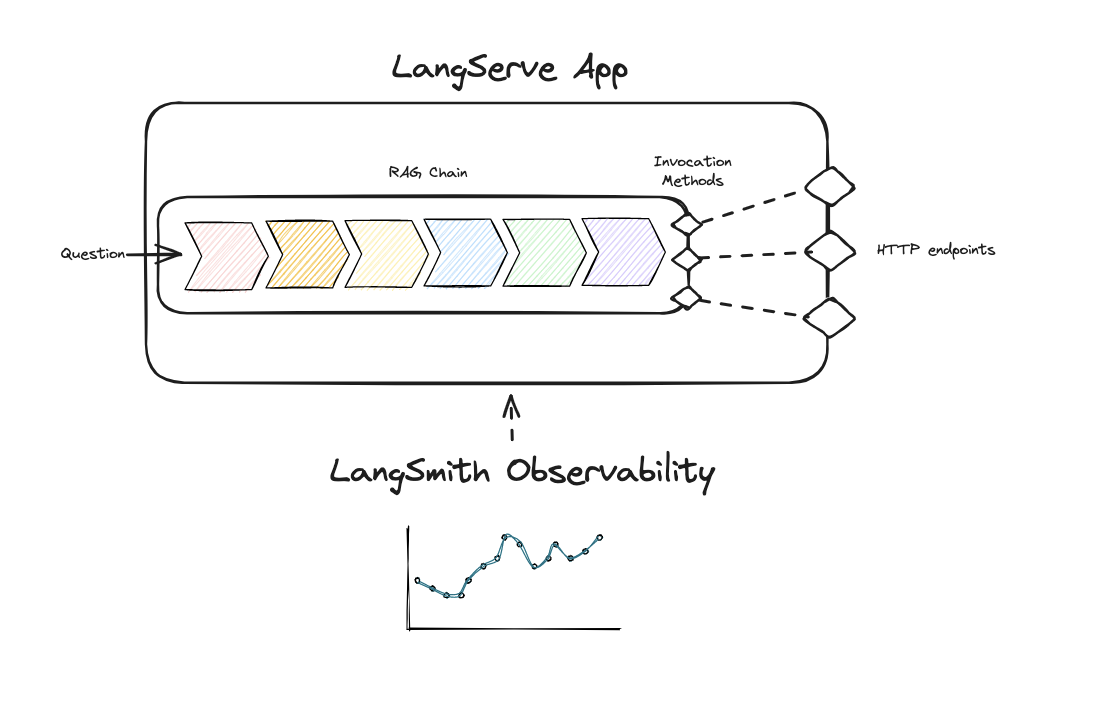

```
$ conda create -n template-testing-env python=3.11
$ conda activate template-testing-env
$ pip install -U "langchain-cli[serve]" "langserve[all]"
$ langchain app new .
$ poetry add langchain-nomic langchain_community tiktoken langchain-openai chromadb langchain
$ poetry install
```

---

Add above logic to new file `chain.py`.

---

Add to `server.py` -

```
from app.chain import chain as nomic_chain
add_routes(app, nomic_chain, path="/nomic-rag")
```

Run - 
```
$ poetry run langchain serve
```